# Colab setup

In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

tcmalloc: large alloc 1073750016 bytes == 0x5ba4e000 @  0x7fc0763552a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
0.4.0
True


In [0]:
!pip3 install Pillow==4.0.0
!pip3 install PIL
!pip3 install image

    100% |████████████████████████████████| 5.6MB 6.7MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


In [0]:
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())
import numpy as np
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

import copy
import random
import re
from tqdm import tqdm

0.4.0
True


In [0]:
!unzip train.zip

Archive:  train.zip
  inflating: training_queries.csv    
  inflating: training_queries_labels.csv  
  inflating: description.txt         


In [0]:
import numpy as np
import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


# Data extraction/ preprocessing

In [0]:
training_queries = pd.read_csv('/content/training_queries.csv')
indexes = training_queries['index']
queries = training_queries['query']
categories = pd.read_csv('/content/training_queries_labels.csv')['tag']

In [0]:
print('Max words:',max([len(x.split(' ')) for x in queries]))
print('Average words per query:',sum([len(x.split(' ')) for x in queries])/len(queries))
print('Max characters:',max([len(x) for x in queries]))
print('Average characters per query:',sum([len(x) for x in queries])/len(queries))
print('No. of examples per category')
print(categories.value_counts().sort_index())
categories = categories.tolist()

Max words: 144
Average words per query: 10.731747787610619
Max characters: 797
Average characters per query: 53.51825221238938
No. of examples per category
0    238
1    185
2    221
3    317
4    305
5     84
6     86
7     95
8     68
9    209
Name: tag, dtype: int64


In [0]:
def normalizeString(s):
    s =s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
#MAX_LENGTH=22

#def filterPair(p):
 #   return len(p.split(' ')) < MAX_LENGTH
  
#def filterPairs(pairs):
 #   return [pair for pair in pairs if filterPair(pair)]


In [0]:
queries = pd.Series([normalizeString(x) for x in queries])

In [0]:
print('Example of normalized query:    ',queries[random.randint(0,len(queries))])

Example of normalized query:     i have changed my mind and no longer want my order


In [0]:
SOS_token = 0
EOS_token = 1
UNK_token = 2


class WordCounter:
    def __init__(self):
        self.words = []
        self.word2count = {}

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.words:
            self.words.append(word)
            self.word2count[word] = 1
        else:
            self.word2count[word] += 1


In [0]:
counter = WordCounter()
for query in queries[:-100]:
  counter.addSentence(query)
  
print('No. of different words:',len(counter.words))
wordCounts = [counter.word2count[x] for x in counter.word2count]
print('No. of words that occur only once (rare words/ possibly typos):',sum([int(x==1) for x in wordCounts]))

No. of different words: 1297
No. of words that occur only once (rare words/ possibly typos): 534


In [0]:
def removeRareWords(countr):
  for word in countr.words:
    if(countr.word2count[word]==1):
      countr.words.remove(word)            #Delete rare word from words
      
removeRareWords(counter)
print('No. of words after removal of rare words:',len(counter.words))

No. of words after removal of rare words: 950


In [0]:
word2index = {"SOS":0,"EOS":1,"UNK":2}
for idx,word in enumerate(counter.words):
  word2index[word] = idx+3 #3 for SOS, EOS and UNK

In [0]:
from itertools import islice
print('Examples of word2index:\n',list(islice(word2index.items(), 30)))

Examples of word2index:
 [('SOS', 0), ('EOS', 1), ('UNK', 2), ('you', 3), ('promised', 4), ('to', 5), ('deliver', 6), ('the', 7), ('phone', 8), ('before', 9), ('day', 10), ('.', 11), ('where', 12), ('is', 13), ('it', 14), ('?', 15), ('i', 16), ('have', 17), ('that', 18), ('my', 19), ('item', 20), ('will', 21), ('be', 22), ('late', 23), ('same', 24), ('delivery', 25), ('available', 26), ('when', 27), ('does', 28), ('your', 29)]


# Functions used in training

In [0]:
def getIndex(word):
  if word in word2index:
    return word2index[word]
  else:
    return word2index['UNK']  
  
def query2indices(query):
  query = query.split(' ')
  indexed_list = [word2index['SOS']]     #StartOfSentence
  indexed_list += ( [getIndex(word) for word in query])
  indexed_list.append(word2index['EOS']) #EndOfSentence
  return torch.tensor(indexed_list)

In [0]:
def predict(query,model):
  with torch.no_grad():
    query = normalizeString(query)
    word_indices = query2indices(query).cuda()
    word_indices = word_indices.view([-1,1])
    out = model(word_indices)
    return torch.argmax(out, dim=1)

In [0]:
def adjust_learning_rate(optimizer, af):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= af

# Training

In [0]:
class Net(nn.Module):
  """
  Computes 1 output from the current context vector.
  h - LSTM hidden state
  c - LSTM memory unit
  
  """
  def __init__(self,word_count, embed_dim, hid_size, op_size, n):
    super(Net, self).__init__()
    self.hid_size = hid_size
    self.embedding = nn.Embedding(word_count,embed_dim)
    self.LSTM = nn.LSTM(input_size=embed_dim,hidden_size=hid_size,num_layers = n)
    self.o2o = nn.Linear(hid_size,op_size)
    #self.softmax = nn.Softmax(1) #dimension
    
  def forward(self, inp):
    #inp -> [(no. of words) x 1]
    output = self.embedding(inp)
    output,(_,_) = self.LSTM(output)
    output = self.o2o(output[output.shape[0]-1,:,:].view([-1,self.hid_size]))                       #[1 x 1 x hid_size]
    #output = self.softmax(output)
    return output    #1x10

In [0]:
def train(BATCH_SIZE=4,ANNEAL_FACTOR=1,EPOCHS=20,ANNEAL_START=0,lrate = 1e-4,num_layers=1):
  
  model = Net(len(word2index),64,256,10,num_layers)
  loss_func = nn.CrossEntropyLoss()
  optimizer = optim.Adam(params = model.parameters(),lr = lrate,weight_decay = 0.01)
  
  losses = []
  model = model.cuda()
  total_losses = []
  validation_accuracies = []
  batch_loss = 0

  model.train()

  for epoch in tqdm(range(EPOCHS)):
    model.train()
    if (epoch>=ANNEAL_START):
      adjust_learning_rate(optimizer,ANNEAL_FACTOR)  #Annealing

    total_loss=0
    for i,query in enumerate(queries[:-100]): 
      target = torch.tensor(categories[i]).cuda().view([1])

      word_indices = query2indices(query).cuda()
      word_indices = word_indices.view([-1,1])
      out = model(word_indices)

      batch_loss += loss_func(out,target)
      #if i%50==0:
      #  print(batch_loss)
      if(i%BATCH_SIZE== BATCH_SIZE - 1):
        batch_loss.backward()
        optimizer.step()
        total_loss+=batch_loss.data
        batch_loss = 0
        optimizer.zero_grad()

    total_losses.append(total_loss)

    #Validation
    model.eval()
    accuracy = 0
    with torch.no_grad():
      for i in range(len(queries)-100,len(queries)):
        query = queries[i]
        target = categories[i]
        accuracy += int(predict(query,model) == target)
    
      #print('Validation accuracy epoch',epoch,':',accuracy/100)
      validation_accuracies.append(accuracy/100)
      #if(i%150==0):
      #  print('Iteration:',i,'Loss:',loss)
      #if(i%10==0): 
      #  losses.append(loss.data)      
    torch.save(model.state_dict(),'epoch'+str(epoch)+'.pt')  
  f,axarr = plt.subplots(2,sharex=True)
  f.suptitle('lr= '+str(lrate)+' bs= '+str(BATCH_SIZE)+ ' af= '+str(ANNEAL_FACTOR)+' from '+str(ANNEAL_START)+' num_layers= '+str(num_layers))
  for ax in axarr:
    ax.label_outer()
  axarr[0].plot(total_losses)
  axarr[0].set(ylabel='loss')

  axarr[1].set_xlabel('epoch')
  axarr[1].plot(validation_accuracies)
  axarr[1].set(ylabel='Validation accuracy')

  plt.show()
  return validation_accuracies,total_losses,model

In [0]:
_,_,model = train(4,1,40,0,1e-4,2)


  0%|          | 0/2 [00:00<?, ?it/s]

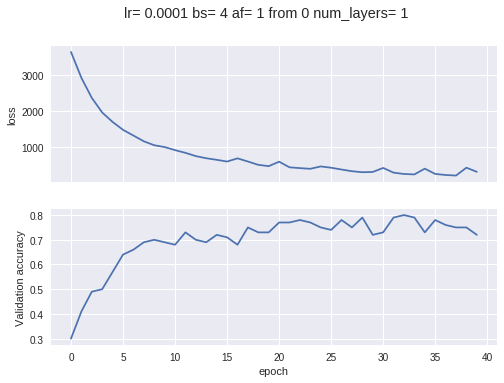

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "

 50%|█████     | 1/2 [06:24<06:24, 384.22s/it]

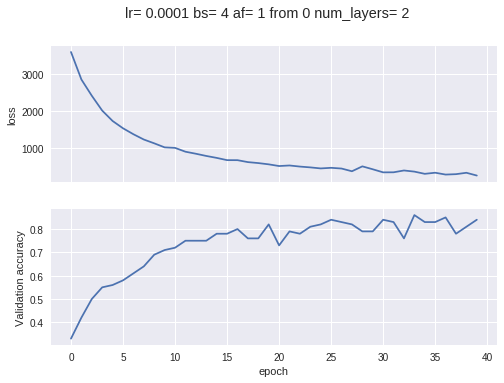


100%|██████████| 2/2 [17:22<00:00, 466.34s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

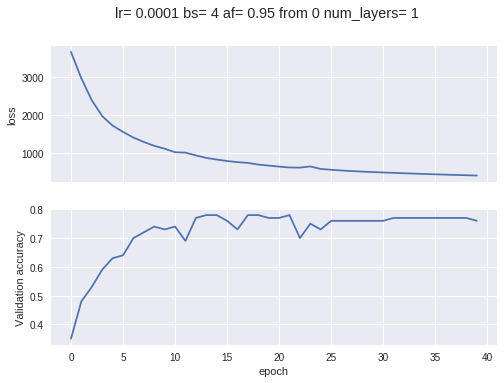


 50%|█████     | 1/2 [06:26<06:26, 386.09s/it]

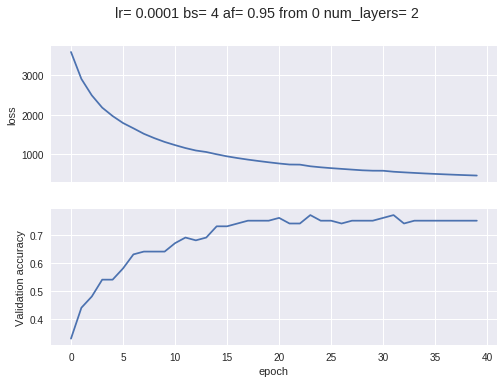


100%|██████████| 2/2 [17:25<00:00, 468.08s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

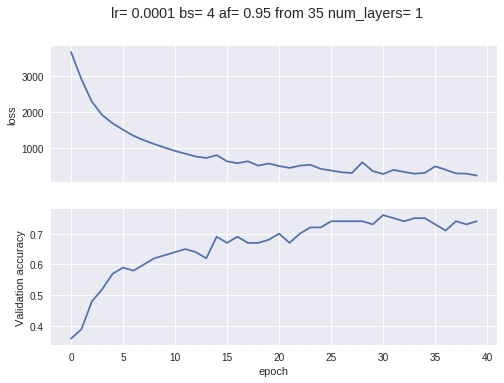


 50%|█████     | 1/2 [06:25<06:25, 385.61s/it]

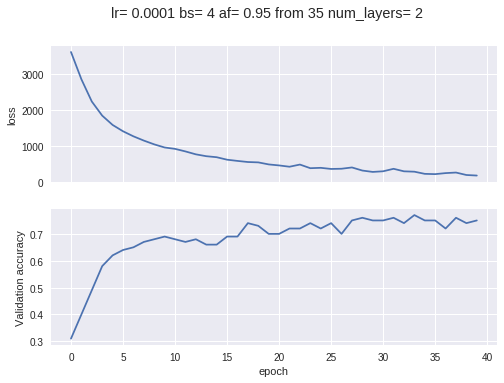


100%|██████████| 2/2 [17:23<00:00, 467.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

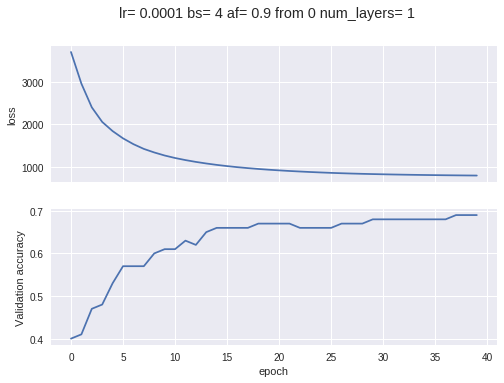


 50%|█████     | 1/2 [06:25<06:25, 385.36s/it]

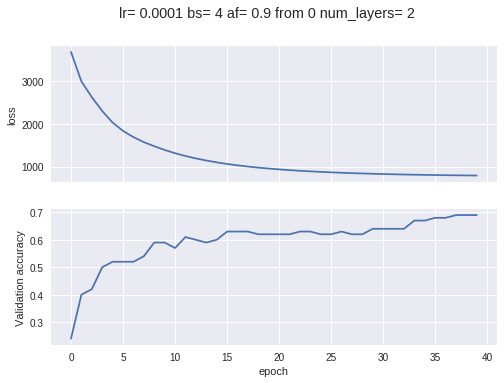


100%|██████████| 2/2 [17:24<00:00, 467.53s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

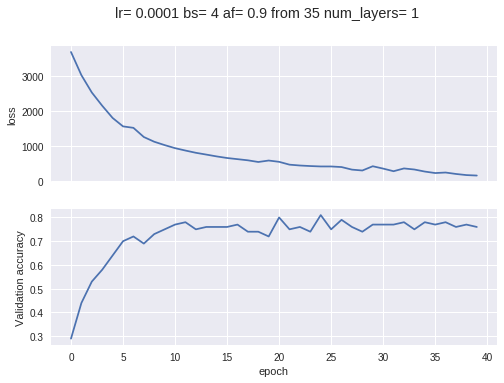


 50%|█████     | 1/2 [06:27<06:27, 387.01s/it]

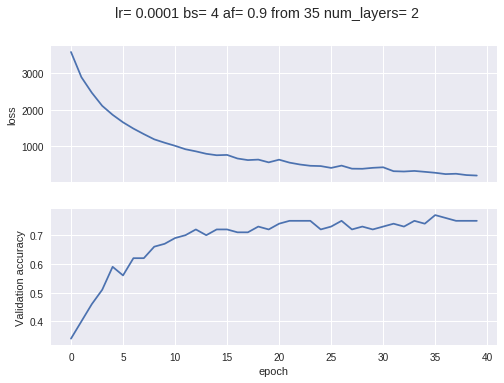


100%|██████████| 2/2 [17:30<00:00, 470.02s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

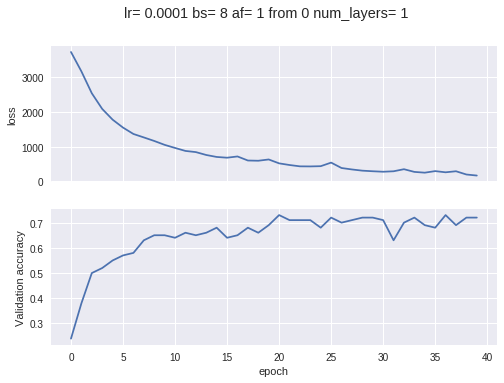


 50%|█████     | 1/2 [06:04<06:04, 364.15s/it]

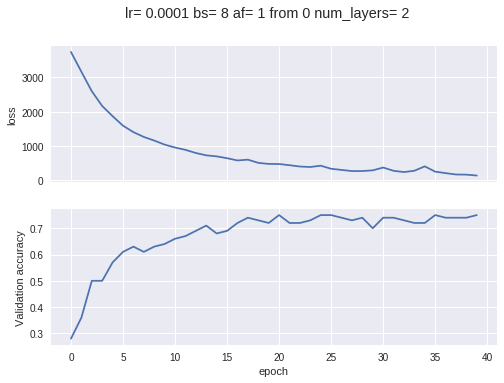


100%|██████████| 2/2 [16:40<00:00, 445.73s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

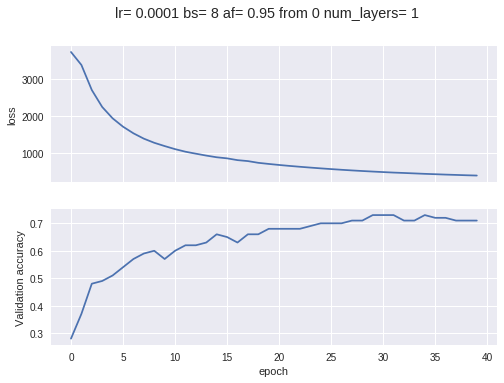


 50%|█████     | 1/2 [09:18<09:18, 558.13s/it]

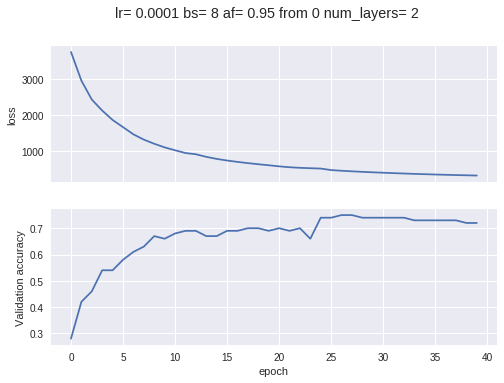


100%|██████████| 2/2 [30:14<00:00, 767.67s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

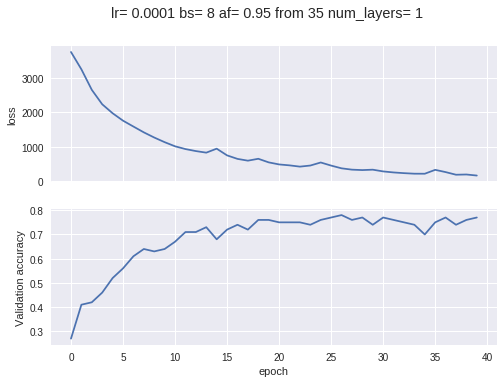


 50%|█████     | 1/2 [13:22<13:22, 802.96s/it]

KeyboardInterrupt: ignored

In [0]:
vas = []
los = []
for bs in [4,8]:
  for af in [1,0.95,0.9]:
    for astr in [0,35]:
      for nl in tqdm([1,2]):
        if((af==1) and (astr==35)):
          continue
        vass,loss,model = train(bs,af,40,astr,1e-4,nl)
        torch.save(model.state_dict(),str(bs)+str(af)+str(astr)+str(nl)+'.pt')
        vas.append(vass)
        los.append(loss)

In [0]:
i = 0
for bs in [4,8]:
  for af in [1,0.95,0.9]:
    for astr in [0,35]:
      for nl in [1,2]:
        i+=1
        f,axarr = plt.subplots(2,sharex=True)
        f.suptitle('lr= '+str(1e-4)+' bs= '+str(bs)+ ' af= '+str(af)+' from '+str(astr)+' num_layers= '+str(nl))
        for ax in axarr:
          ax.label_outer()
        axarr[0].plot(los[i])
        axarr[0].set(ylabel='loss')

        axarr[1].set_xlabel('epoch')
        axarr[1].plot(vas[i])
        axarr[1].set(ylabel='Validation accuracy')

        plt.show()

In [0]:
import matplotlib.pyplot as plt
f,axarr = plt.subplots(2,sharex=True)
f.suptitle('lr=1e-4 wd=0.01 bs=4 af = 1 2x layers')
for ax in axarr:
  ax.label_outer()
axarr[0].plot(total_losses)
axarr[0].set(ylabel='loss')

axarr[1].set_xlabel('epoch')
axarr[1].plot(validation_accuracies)
axarr[1].set(ylabel='Validation accuracy')

plt.show()

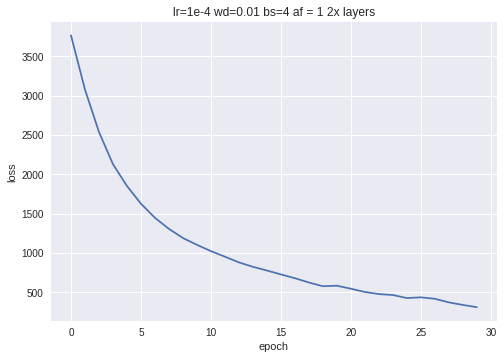

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=4 af = 1 2x layers')
plt.show()

In [0]:
#Import word embeddings.
#Look at data again
#Put a validation set

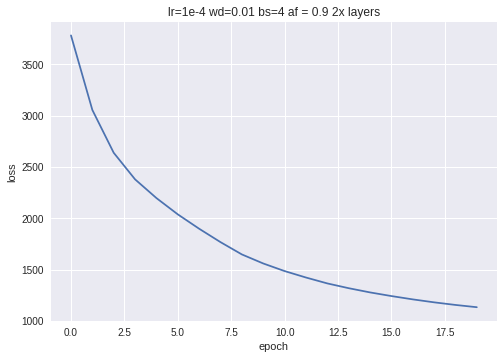

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=4 af = 0.9 2x layers')
plt.show()

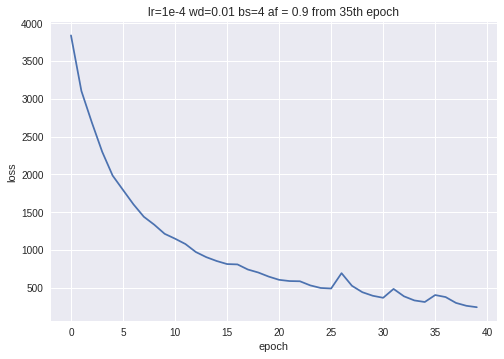

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=4 af = 0.9 from 35th epoch')
plt.show()

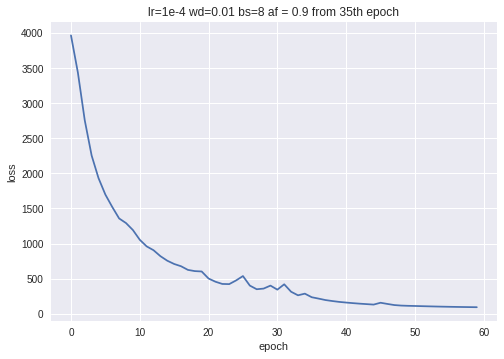

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=8 af = 0.9 from 35th epoch')
plt.show()

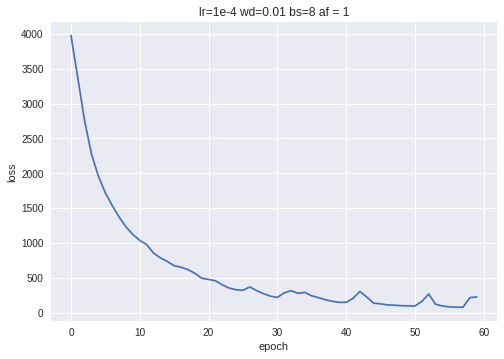

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=8 af = 1')
plt.show()

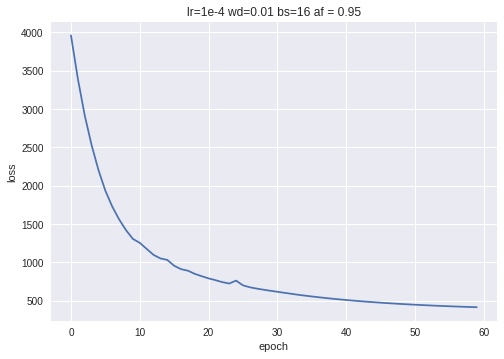

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=8 af = 0.95')
plt.show()

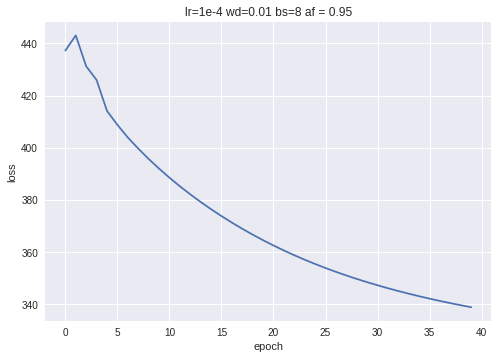

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=8 af = 0.95')
plt.show()

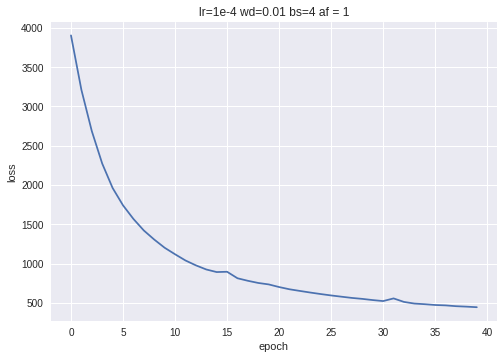

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=4 af = 1')
plt.show()

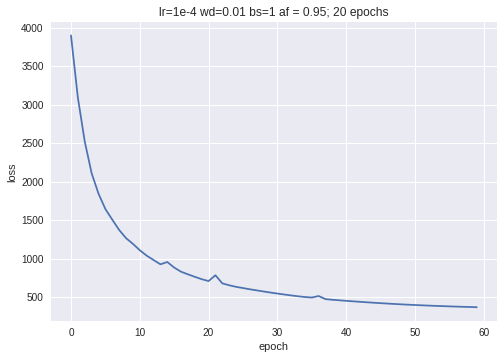

In [0]:
import matplotlib.pyplot as plt
plt.plot(total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('lr=1e-4 wd=0.01 bs=4 af = 0.95')
plt.show()

# Model analysis

In [0]:
print(model)

Net(
  (embedding): Embedding(988, 64)
  (LSTM): LSTM(64, 256)
  (o2o): Linear(in_features=256, out_features=10, bias=True)
)


In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  
print('No. of parameters:',count_parameters(model))

No. of parameters: 921866


# Testing


In [0]:
test = pd.read_csv('/content/test1.csv',encoding = "ISO-8859-1")
test_indices = test['index']
test_queries = test['query']

In [0]:
from tqdm import tqdm
model.load_state_dict(torch.load('epoch36.pt'))
model.eval()
df = pd.DataFrame(columns=['index','tag'])
for i,query in enumerate(tqdm(test_queries)):
  prediction  = predict(query,model)
  df.loc[i+1] = [test_indices[i],prediction.cpu().numpy()[0]]
df.to_csv('answer.csv',index=False)